In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Carga de archivos

df_clientes = pd.read_csv(r"data/clean/clientes.csv")
df_productos = pd.read_csv(r"data/clean/productos.csv")
df_ventas = pd.read_csv(r"data/clean/ventas.csv")
df_detalle = pd.read_csv(r"data/clean/detalle_ventas.csv")


In [3]:
# Parsear fechas
df_ventas['fecha'] = pd.to_datetime(df_ventas['fecha'])
df_clientes['fecha_alta'] = pd.to_datetime(df_clientes['fecha_alta'])

# Fecha de referencia (última fecha en datos)
FECHA_REF = df_ventas['fecha'].max()
print(f"Fecha maxima: {FECHA_REF}")
print(f"Total clientes: {len(df_clientes)}")
print(f"Total ventas: {len(df_ventas)}")
print(f"Total productos: {len(df_productos)}")
print(f"Total líneas detalle: {len(df_detalle)}")

Fecha maxima: 2024-10-31 21:49:00
Total clientes: 1531
Total ventas: 113882
Total productos: 100
Total líneas detalle: 279528


In [4]:
# Join detalle con productos para categorías
df_full = df_detalle.merge(
    df_productos[['id_producto', 'categoria']], 
    on='id_producto',
    how='left'
)

# Join con ventas para fechas
df_full = df_full.merge(
    df_ventas[['id_venta', 'id_cliente', 'fecha']], 
    on='id_venta',
    how='left'
)

print(f"Dataset completo: {len(df_full)} registros")

Dataset completo: 279528 registros


#### Feature Engineering

In [5]:
# 1. FEATURES RFM

# Recency: días desde última compra
recency = df_full.groupby('id_cliente')['fecha'].max().reset_index()
recency['recency_dias'] = (FECHA_REF - recency['fecha']).dt.days
recency = recency[['id_cliente', 'recency_dias']]

# Frequency: número de compras únicas
frequency = df_ventas.groupby('id_cliente')['id_venta'].nunique().reset_index()
frequency.columns = ['id_cliente', 'frequency']

# # Monetary: gasto total
monetary = df_full.groupby('id_cliente')['importe'].sum().reset_index()
monetary.columns = ['id_cliente', 'monetary']

# Combinar RFM
features = recency.merge(frequency, on='id_cliente')
features = features.merge(monetary, on='id_cliente')

In [6]:
# DEFINIR FEATURE SETS PARA CLUSTERING

# Excluir id_cliente
X_all = features.drop('id_cliente', axis=1)

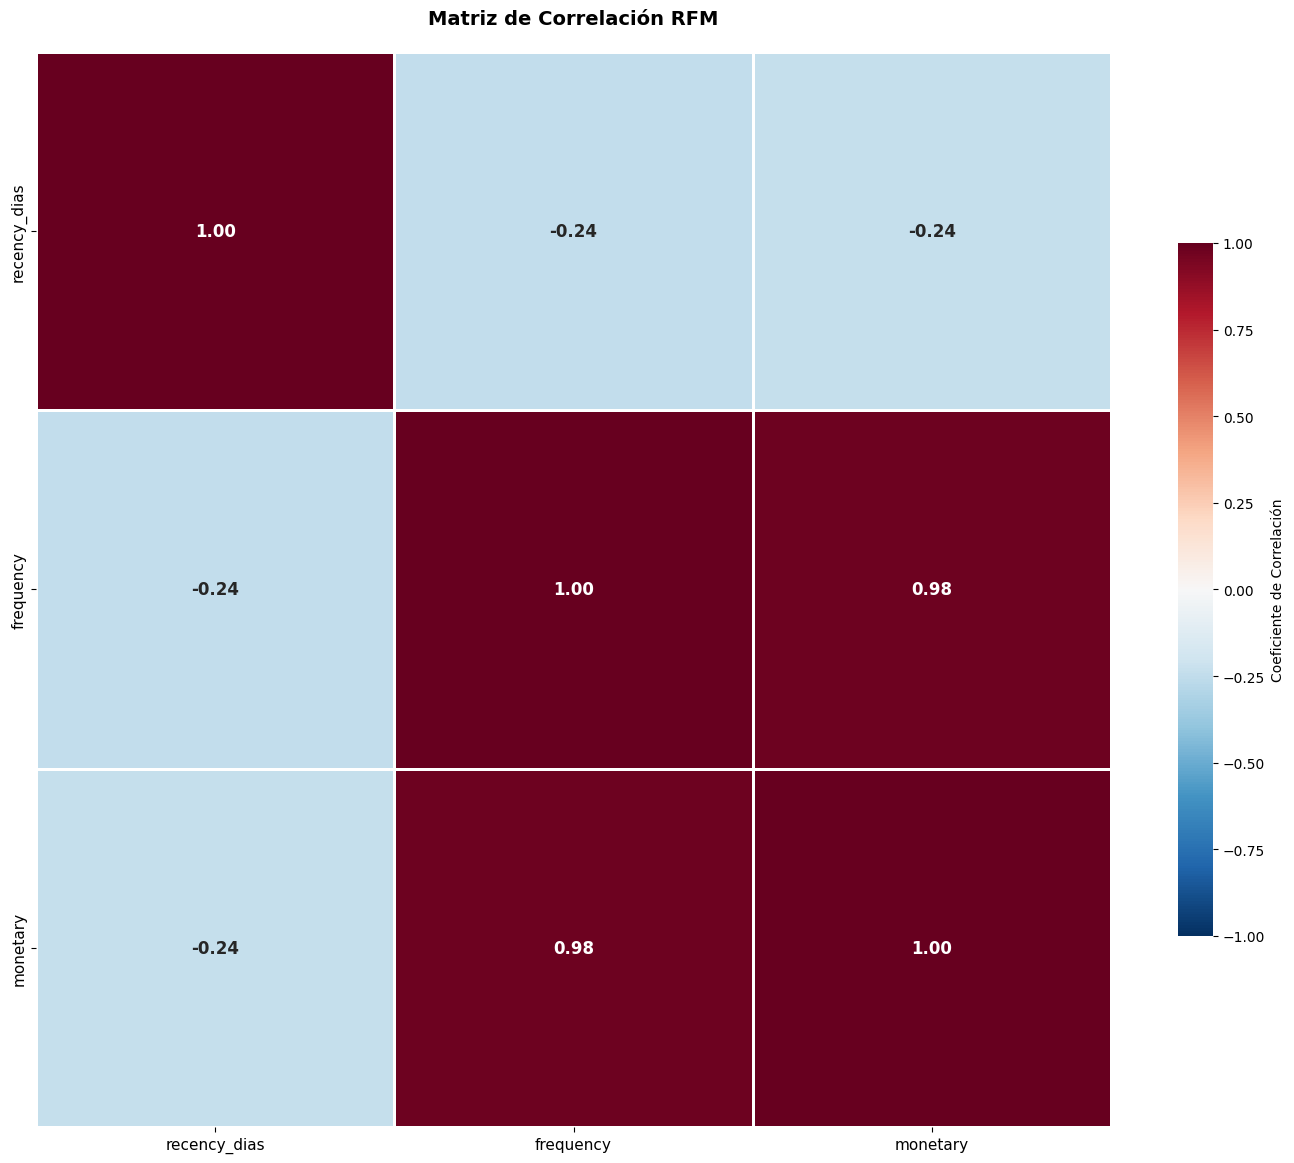

In [7]:
corr_matrix = X_all.corr()

# Visualización
fig, ax = plt.subplots(figsize=(14, 12))

# Visualizar la matriz con un mapa de calor más compacto
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', fmt=".2f",
            linewidths=1, vmin=-1, vmax=1, square=True,
            cbar_kws={'shrink': 0.6, 'label': 'Coeficiente de Correlación'},
            annot_kws={'fontsize': 12, 'fontweight': 'bold'})

plt.title('Matriz de Correlación RFM', fontsize=14, fontweight='bold', pad=20)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()

In [8]:

# Identificar correlaciones altas
print("\n🔍 Features con correlación alta (|r| > 0.5):")
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr.append({
                'feature_1': corr_matrix.columns[i],
                'feature_2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i, j]
            })

if high_corr:
    df_high_corr = pd.DataFrame(high_corr).sort_values('correlation', 
                                                        key=abs, 
                                                        ascending=False)
    print(df_high_corr.to_string(index=False))
else:
    print("   ✓ No hay correlaciones altas detectadas")



🔍 Features con correlación alta (|r| > 0.5):
feature_1 feature_2  correlation
frequency  monetary     0.982379


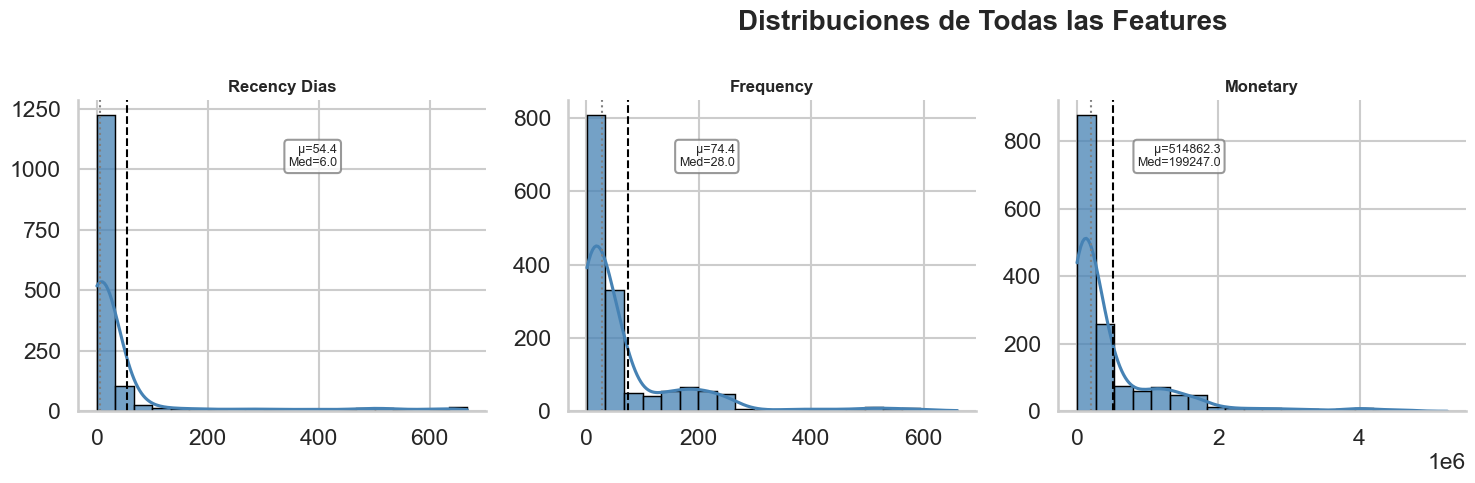

In [9]:
sns.set_style("whitegrid")
sns.set_context("talk")

# Crear una grilla más grande para acomodar 14 features
n_features = len(X_all.columns)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols  # Redondear hacia arriba

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
fig.suptitle('Distribuciones de Todas las Features', fontsize=20, weight='bold')
fig.subplots_adjust(top=0.95, wspace=0.3, hspace=0.4)

# Aplanar axes para facilitar iteración
axes = axes.flatten()

# Helper para dibujar media/mediana
def _annotate_stats(ax, data, xpos='right'):
    mean = data.mean()
    median = data.median()
    ymax = ax.get_ylim()[1]
    ax.axvline(mean, color='k', linestyle='--', linewidth=1.5)
    ax.axvline(median, color='gray', linestyle=':', linewidth=1.5)
    
    # Posición del texto
    x_text = data.quantile(0.95) if xpos == 'right' else data.quantile(0.05)
    ax.text(x_text, ymax*0.82, f"μ={mean:.1f}\nMed={median:.1f}", 
            ha='right' if xpos == 'right' else 'left', va='center',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8), 
            fontsize=9)

# Crear histogramas para cada feature
for idx, col in enumerate(X_all.columns):
    ax = axes[idx]
    
    # Histograma
    sns.histplot(X_all[col], bins=20, kde=True, 
                color='steelblue', alpha=0.75, edgecolor='k', ax=ax)
    
    # Títulos y etiquetas
    ax.set_title(col.replace('_', ' ').title(), fontsize=12, weight='semibold')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Estadísticas
    _annotate_stats(ax, X_all[col])
    sns.despine(ax=ax)

# Ocultar ejes sobrantes si los hay
for idx in range(n_features, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

In [10]:
stats = pd.DataFrame({
    'feature': X_all.columns,
    'skewness': X_all.skew(),
    'kurtosis': X_all.kurtosis(),
    'min': X_all.min(),
    'max': X_all.max(),
    'zeros_%': (X_all == 0).sum() / len(X_all) * 100
}).round(3)

print(stats.to_string(index=False))

     feature  skewness  kurtosis   min       max  zeros_%
recency_dias     3.135     8.961   0.0     668.0    13.39
   frequency     2.607     7.536   1.0     660.0     0.00
    monetary     2.785     8.877 272.0 5242937.0     0.00


In [11]:
import pandas as pd

# Calcular outliers con regla 1.5*IQR para cada columna
outlier_stats = []

for col in X_all.columns:
    Q1 = X_all[col].quantile(0.25)
    Q3 = X_all[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_mask = (X_all[col] < lower_bound) | (X_all[col] > upper_bound)
    n_outliers = outliers_mask.sum()
    pct_outliers = (n_outliers / len(X_all)) * 100
    
    outlier_stats.append({
        'feature': col,
        'n_outliers': n_outliers,
        'pct_outliers': round(pct_outliers, 2),
        'lower_bound': round(lower_bound, 2),
        'upper_bound': round(upper_bound, 2)
    })

df_outliers = pd.DataFrame(outlier_stats).sort_values('pct_outliers', ascending=False)
print(df_outliers.to_string(index=False))

     feature  n_outliers  pct_outliers  lower_bound  upper_bound
   frequency         263         17.18       -78.00       154.00
recency_dias         224         14.63       -29.50        54.50
    monetary         196         12.80   -674130.25   1275079.75


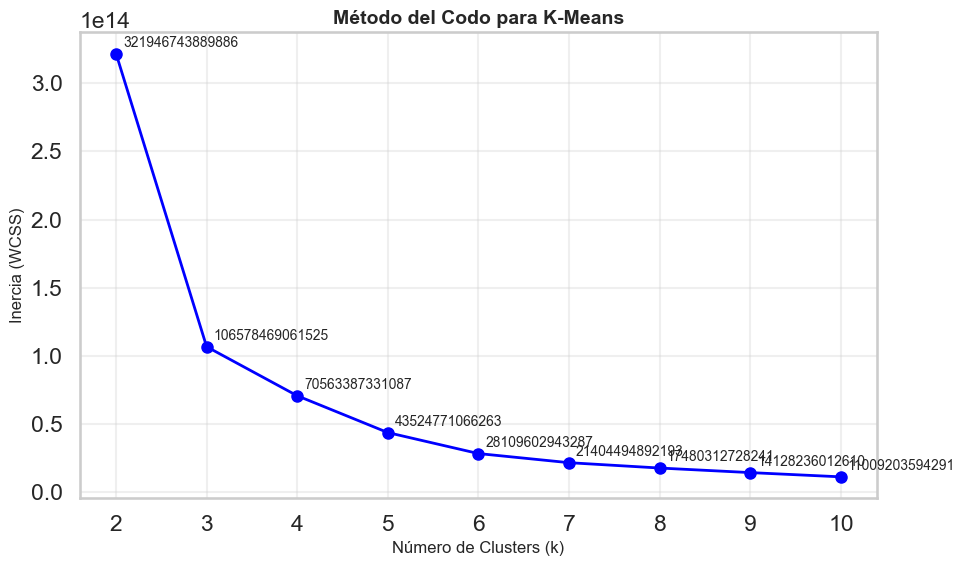

Análisis del Método del Codo:
    k       inertia     reduction
0   2  3.219467e+14  0.000000e+00
1   3  1.065785e+14  2.153683e+14
2   4  7.056339e+13  3.601508e+13
3   5  4.352477e+13  2.703862e+13
4   6  2.810960e+13  1.541517e+13
5   7  2.140449e+13  6.705108e+12
6   8  1.748031e+13  3.924182e+12
7   9  1.412824e+13  3.352077e+12
8  10  1.100920e+13  3.119032e+12


In [12]:
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

# Método del codo
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_all)
    inertias.append(kmeans.inertia_)

# Gráfico del codo
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.title('Método del Codo para K-Means', fontsize=14, fontweight='bold')
plt.xlabel('Número de Clusters (k)', fontsize=12)
plt.ylabel('Inercia (WCSS)', fontsize=12)
plt.grid(True, alpha=0.3)

# Añadir valores en cada punto
for i, inertia in enumerate(inertias):
    plt.annotate(f'{inertia:.0f}', 
                xy=(K_range[i], inertia), 
                xytext=(5, 5), 
                textcoords='offset points',
                fontsize=10)

plt.tight_layout()
plt.show()

# Mostrar tabla de resultados
elbow_results = pd.DataFrame({
    'k': K_range,
    'inertia': inertias,
    'reduction': [0] + [inertias[i-1] - inertias[i] for i in range(1, len(inertias))]
})

print("Análisis del Método del Codo:")
print(elbow_results.round(2))

In [13]:
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Clustering
kmeans_no_scale = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_no_scale = kmeans_no_scale.fit_predict(X_all)

# Reducción dimensional para visualizar (PCA)
pca = PCA(n_components=2, random_state=42)
X_pca_no_scale = pca.fit_transform(X_all)

# Crear dataframe para plotly
df_plot_no_scale = pd.DataFrame({
    'PC1': X_pca_no_scale[:, 0],
    'PC2': X_pca_no_scale[:, 1],
    'Cluster': labels_no_scale.astype(str),
    'Monetary': X_all['monetary'].values,
    'Frequency': X_all['frequency'].values,
    'Recency': X_all['recency_dias'].values
})

# Plot
fig1 = px.scatter(
    df_plot_no_scale,
    x='PC1', y='PC2',
    color='Cluster',
    hover_data=['Monetary', 'Frequency', 'Recency'],
    title=f'+Varianza explicada: {pca.explained_variance_ratio_.sum():.2%}',
    width=800, height=600
)
fig1.show()

c:\Users\Dell\anaconda3\envs\demo\lib\site-packages\plotly\express\_core.py:2065: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


In [14]:
pd.DataFrame(labels_no_scale).value_counts()

0
0    1209
2     262
1      60
Name: count, dtype: int64

In [15]:
X_all[pd.DataFrame(labels_no_scale)[0] == 2].describe().round(2)

,recency_dias,frequency,monetary
count,262.00,262.00,262.00
mean,2.27,197.25,1349135.55
std,2.49,52.50,376251.87
min,0.00,93.00,771218.00
25%,0.00,158.25,1057190.25
50%,2.00,193.00,1300012.50
75%,3.00,227.00,1610063.25
max,16.00,436.00,2443199.00


In [16]:
from sklearn.preprocessing import RobustScaler, StandardScaler

# scaler = RobustScaler()
scaler = StandardScaler()
X_robust = scaler.fit_transform(X_all)
X_train = pd.DataFrame(X_robust, columns=X_all.columns)

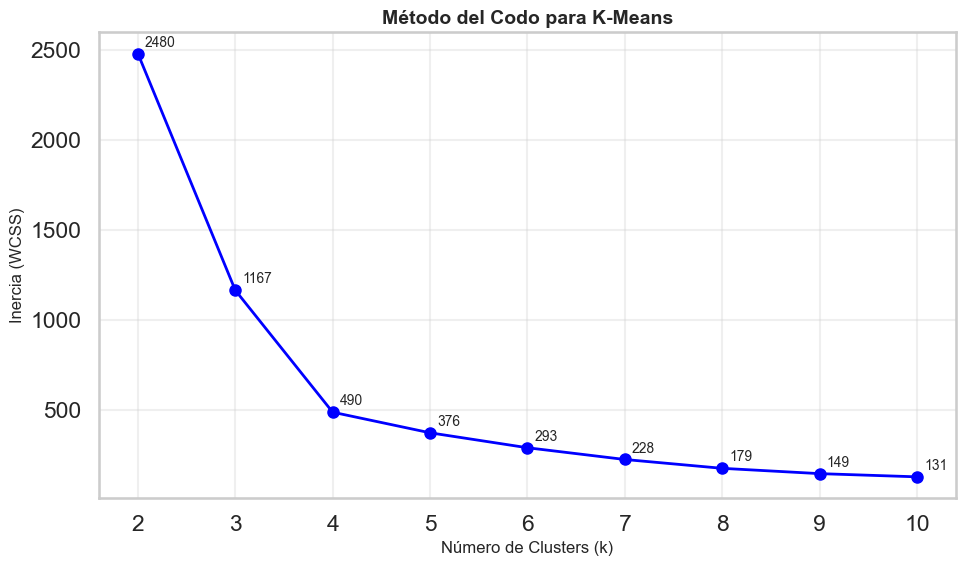

Análisis del Método del Codo:
    k  inertia  reduction
0   2  2479.92       0.00
1   3  1166.58    1313.34
2   4   490.03     676.54
3   5   375.71     114.32
4   6   292.84      82.87
5   7   227.66      65.18
6   8   178.67      48.99
7   9   149.21      29.46
8  10   131.44      17.77


In [17]:
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

# Método del codo
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train)
    inertias.append(kmeans.inertia_)

# Gráfico del codo
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.title('Método del Codo para K-Means', fontsize=14, fontweight='bold')
plt.xlabel('Número de Clusters (k)', fontsize=12)
plt.ylabel('Inercia (WCSS)', fontsize=12)
plt.grid(True, alpha=0.3)

# Añadir valores en cada punto
for i, inertia in enumerate(inertias):
    plt.annotate(f'{inertia:.0f}', 
                xy=(K_range[i], inertia), 
                xytext=(5, 5), 
                textcoords='offset points',
                fontsize=10)

plt.tight_layout()
plt.show()

# Mostrar tabla de resultados
elbow_results = pd.DataFrame({
    'k': K_range,
    'inertia': inertias,
    'reduction': [0] + [inertias[i-1] - inertias[i] for i in range(1, len(inertias))]
})

print("Análisis del Método del Codo:")
print(elbow_results.round(2))

In [18]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

results = []

for k in range(3, 8):
    # K-means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_km = kmeans.fit_predict(X_train)
    
    # Hierarchical
    hier = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels_hier = hier.fit_predict(X_train)
    
    # Métricas
    for name, labels in [('kmeans', labels_km), ('hierarchical', labels_hier)]:
        results.append({
            'method': name,
            'k': k,
            'silhouette': silhouette_score(X_train, labels),
            'calinski': calinski_harabasz_score(X_train, labels),
            'davies': davies_bouldin_score(X_train, labels)
        })

df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

      method  k  silhouette    calinski   davies
      kmeans  3    0.707867 2243.988616 0.535033
hierarchical  3    0.691829 2024.376233 0.524345
      kmeans  4    0.713607 4261.763212 0.406341
hierarchical  4    0.696888 3776.525054 0.394413
      kmeans  5    0.701162 4282.270161 0.445725
hierarchical  5    0.662627 4141.892481 0.487591
      kmeans  6    0.647005 4478.904864 0.537078
hierarchical  6    0.526247 4184.129326 0.531513
      kmeans  7    0.528929 4870.393369 0.583387
hierarchical  7    0.520297 4389.646287 0.575639


In [ ]:
# Clustering
kmeans_scaled = KMeans(n_clusters=4, random_state=42, n_init='auto')
labels_scaled = kmeans_scaled.fit_predict(X_train)

# PCA
pca2 = PCA(n_components=2, random_state=42)
X_pca_scaled = pca2.fit_transform(X_train)

# Dataframe
df_plot_scaled = pd.DataFrame({
    'PC1': X_pca_scaled[:, 0],
    'PC2': X_pca_scaled[:, 1],
    'Cluster': labels_scaled.astype(str),
    'Monetary': X_all['monetary'].values,
    'Frequency': X_all['frequency'].values,
    'Recency': X_all['recency_dias'].values,
})

# Plot
fig2 = px.scatter(
    df_plot_scaled,
    x='PC1', y='PC2',
    color='Cluster',
    hover_data=['Monetary', 'Frequency', 'Recency'],
    title=f'Varianza explicada: {pca2.explained_variance_ratio_.sum():.2%}',
    width=800, height=600
)
fig2.show()

c:\Users\Dell\anaconda3\envs\demo\lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [21]:
pd.DataFrame(labels_scaled).value_counts()

0
0    1075
1     268
2     127
3      61
Name: count, dtype: int64

In [25]:
X_all[pd.DataFrame(labels_scaled)[0] == 0].mean().round(2)

recency_dias        21.34
frequency           29.03
monetary        199755.14
dtype: float64

In [23]:
X_all[pd.DataFrame(labels_scaled)[0] == 1].mean().round(2)

recency_dias          2.29
frequency           194.39
monetary        1328058.30
dtype: float64

In [24]:
X_all[pd.DataFrame(labels_scaled)[0] == 3].mean().round(2)

recency_dias          1.34
frequency           499.16
monetary        3553900.56
dtype: float64